In [1]:
#figure 4
from scipy.integrate import odeint
from pylab import *
from lmfit import *
from scipy import stats
%matplotlib inline

# This results in all bare variable names printing output
# As suggested in https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

site = 'Site 3C'

# Load data for the selected site
if site == 'Site 3C':
    A=np.array([\
    [1981.27,1.34,0.07,0.004,0.0081,0.0062,0.0076],\
    [1992.51,0.71,0.25,0.012,0.0066,0.0049,0.0064],\
    [2003.58,0.39,0.32,0.036,0.0050,0.0037,0.0050],\
    [2009.23,0.38,0.52,0.069,0.0076,0.0076,0.0085],\
    [2010.31,0.41,0.52,0.085,0.0075,0.0072,0.0079]])
if site == 'Site 6C':
    A=np.array([\
    [1992.52,3.07,0.67,0.026,0.0182,0.0119,0.0152],\
    [2003.58,2.75,0.87,0.072,0.0177,0.0122,0.0158],\
    [2009.23,2.37,0.75,0.095,0.0172,0.0095,0.0134],\
    [2010.31,1.16,0.43,0.046,0.0079,0.0054,0.0065]])

t = A[:,0]
DDE=A[:,1]
DDMU=A[:,2]
DDNU=A[:,3]
PCB118=A[:,4]
PCB153=A[:,5]
PCB138=A[:,6]

print("Data from {0} with shape {1}".format(site,A.shape))
print('\n'.join([''.join(['{:5.4f}  '.format(item) for item in row]) 
      for row in A]))

# guess at std. error in measurements per conv. with R.E.
stde_DDE  = 0.05          #RE suggests 0.05
stde_DDMU = 0.1          #RE suggested 0.1
stde_DDNU = 0.1          #RE suggested 0.1
stde_PCB  = 0.2          # std. error of measurements is around 0.2
eps_DDE  = stde_DDE*DDE  
eps_DDMU = stde_DDMU*DDMU #RE suggested 0.1
eps_DDNU = stde_DDNU*DDNU #RE suggested 0.2

# calculate adjustment according to mean of all PCBs inventory
pcbm = A[:,4:6].mean(axis=1)
adj_all = pcbm.mean()/pcbm
adj_pcb118 = mean(PCB118)/PCB118
adj_pcb153 = mean(PCB153)/PCB153
adj_pcb138 = mean(PCB138)/PCB138

# Objective function to minimize, estimate origin and decay rate
def residual2(params, t, data, eps_data):
    C0 = params['init_conc']
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)**2/eps_data**2

# Figure 4 with CRS PCB118 adjustment
data = DDE*adj_pcb118
#eps_data = eps_DDE
eps_data = DDE*np.sqrt(stde_DDE**2+stde_PCB**2)
params = Parameters()
params.add('decay_rate',value = 0.4, min =0., max = 1.)
params.add('init_conc',value = data[0], min =0., max = 5.*data[0])

out = minimize(residual2, params, method='leastsq', args=(t,data,eps_data))
# Get the fitted rates
k1f_adj =out.params['decay_rate'].value
k1e_adj =out.params['decay_rate'].stderr
Cof_adj =out.params['init_conc'].value
Coe_adj =out.params['init_conc'].stderr

# Get fit metrics
chis = out.chisqr
chir = out.redchi
report_fit(out)
# Calculate fit profile
Chat_adj = Cof_adj*np.exp(-k1f_adj*(t-t[0]))
r2_adj = np.corrcoef(data, Chat_adj)[0,1]**2

# no adjustment
data = DDE
eps_data = eps_DDE
params = Parameters()
params.add('decay_rate',value = 0.4, min =0., max = 1.)
params.add('init_conc',value = data[0], min =0., max = 5.*data[0])

out = minimize(residual2, params, method='leastsq', args=(t,data,eps_data))
# Get the fitted rates
k1f = out.params['decay_rate'].value
k1e = out.params['decay_rate'].stderr
Cof = out.params['init_conc'].value
Coe = out.params['init_conc'].stderr

# Get fit metrics
chis = out.chisqr
chir = out.redchi
report_fit(out)
# Calculate fit profile
Chat = Cof*np.exp(-k1f*(t-t[0]))
rsq = np.corrcoef(data, Chat)[0,1]**2
r2 = sum(data-Chat)**2

Data from Site 3C with shape (5L, 7L)
1981.2700  1.3400  0.0700  0.0040  0.0081  0.0062  0.0076  
1992.5100  0.7100  0.2500  0.0120  0.0066  0.0049  0.0064  
2003.5800  0.3900  0.3200  0.0360  0.0050  0.0037  0.0050  
2009.2300  0.3800  0.5200  0.0690  0.0076  0.0076  0.0085  
2010.3100  0.4100  0.5200  0.0850  0.0075  0.0072  0.0079  
[[Fit Statistics]]
    # function evals   = 52
    # data points      = 5
    # variables        = 2
    chi-square         = 0.239
    reduced chi-square = 0.080
    Akaike info crit   = -11.196
    Bayesian info crit = -11.977
[[Variables]]
    decay_rate:   0.04137149 +/- 0.003420 (8.27%) (init= 0.4)
    init_conc:    1.24878625 +/- 0.096989 (7.77%) (init= 1.151407)
[[Correlations]] (unreported correlations are <  0.100)
    C(decay_rate, init_conc)     =  0.933 
[[Fit Statistics]]
    # function evals   = 72
    # data points      = 5
    # variables        = 2
    chi-square         = 283.454
    reduced chi-square = 94.485
    Akaike info crit   = 

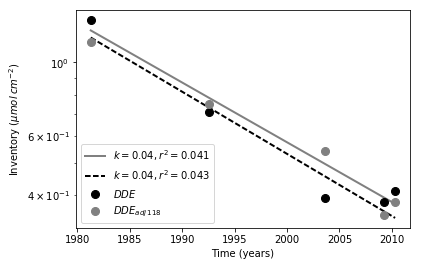

In [5]:
# suppress chatter from Matplotlib
InteractiveShell.ast_node_interactivity = "none"

ts1 = r"$k = {0:.2f}, r^2 = {0:5.3f}$".format(k1f_adj,r2_adj)
ts2 = r"$k = {0:.2f}, r^2 = {0:5.3f}$".format(k1f,r2)

fig = plt.figure()
plt.semilogy(t,Chat_adj,'-',color='gray',linewidth=2,label=ts1)
plt.semilogy(t,Chat,'--',color='black',linewidth=2,label=ts2)
plt.semilogy(t,DDE,'o',color='black',markersize=8,linestyle='None',label='$DDE$')
plt.semilogy(t,DDE*adj_pcb118,'o',color='gray',markersize=8,linestyle='None',label='$DDE_{adj \: 118}$')
plt.xlabel('Time (years)')
plt.ylabel('Inventory ($\mu mol \: cm^{-2}$)')
plt.legend(loc='lower left')

